**------------------------------------------------------------------------------------------------------------------------------------------------------**

**Input: Prediction(s) obtained from a trained GNN - GraphSAGE, GCN and GAT**

**Purpose: Return a small subgraph of the input graph that contains the most important nodes and edges that were most influential for the prediction(s) using Integrated Gradients and Saliency**

**------------------------------------------------------------------------------------------------------------------------------------------------------**

# Librairies

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json

import os
import re
import random
import itertools
import import_ipynb

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import dgl
import dgl.nn as dglnn
import dgl.function as fn
from dgl.nn import HeteroGraphConv, SAGEConv, GraphConv, GATConv
from dgl.data.utils import save_graphs, load_graphs

from torch_geometric.explain import characterization_score

from captum.attr import Saliency, IntegratedGradients

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from functools import partial

import warnings
warnings.simplefilter("ignore")

**Define GNN variant**

In [89]:
gnn_variant = 'GAT'
# gnn_variant = 'GraphSAGE'
# gnn_variant = 'GCN'

**Define etype: we only want to predict one edge type**

In [90]:
etype = ('Compound', 'DRUGBANK::treats::Compound:Disease', 'Disease')

**Get a trained GNN**

In [91]:
from TrainGNN import Net, HeteroDotProductPredictor, construct_negative_graph

In [92]:
model = torch.load(f'GNNModels/{gnn_variant}')

**Get DGL graphs**

In [93]:
g_list = load_graphs('Input/AlzheimerGraph')

In [94]:
g = g_list[0][0]
g_neg = g_list[0][1]

**Get entity dictionary**

In [95]:
with open("Input/entity_dictionary_alzheimer.json") as file:
    entity_dictionary = json.load(file)

# 2) Get Explainability

**Forward function that returns a single tensor**

In [79]:
def model_forward(x, ntype, pos_g, neg_g, input_features, etype, idx):
    input_features = input_features.copy()
    input_features[ntype] = x
    return model(pos_g, neg_g, input_features, etype)[0][idx].reshape([1, 1])

**Forward function with edge weights that returns a single tensor**

In [80]:
def model_forward_edge_weight(x, imp_etype, pos_g, neg_g, input_features, etype, edge_weight, idx):
    edge_weight = edge_weight.copy()
    edge_weight[imp_etype] = x
    return model(pos_g, neg_g, input_features, etype, edge_weight)[0][idx].reshape([1, 1])

**Function that scales attributes to [0, 1]**

In [81]:
def scale(x):
    x = x.abs().sum(dim=1)
    x /= x.max()
    return x

**Function that returns most important nodes**

In [82]:
def get_attr_node(ntype, etype, input_features, pos_g, neg_g, idx):
    x_ntype = input_features[ntype]
    
    ig = IntegratedGradients(partial(model_forward,
                                     ntype=ntype, pos_g=pos_g, neg_g=neg_g, input_features=input_features, 
                                     etype=etype, idx=idx))
    ig_attr_node = ig.attribute(x_ntype, target=0, internal_batch_size=1, n_steps=50)
    
    saliency = Saliency(partial(model_forward,
                                ntype=ntype, pos_g=pos_g, neg_g=neg_g, input_features=input_features, 
                                etype=etype, idx=idx))
    saliency_attr_node = saliency.attribute(x_ntype, target=0)
    
    return scale(ig_attr_node), scale(saliency_attr_node)

**Function that returns most important edges**

In [83]:
def get_attr_edge(imp_etype, etype, input_features, pos_g, neg_g, edge_weight, idx):
    x_etype = edge_weight[imp_etype]

    ig = IntegratedGradients(partial(model_forward_edge_weight,
                                     imp_etype=imp_etype, pos_g=pos_g, neg_g=neg_g, input_features=input_features, 
                                     etype=etype, edge_weight=edge_weight, idx=idx))
    ig_attr_edge = ig.attribute(x_etype, target=0, internal_batch_size=1, n_steps=50)
    
    saliency = Saliency(partial(model_forward_edge_weight,
                                imp_etype=imp_etype, pos_g=pos_g, neg_g=neg_g, input_features=input_features, 
                                etype=etype, edge_weight=edge_weight, idx=idx))
    saliency_attr_edge = saliency.attribute(x_etype, target=0)
    
    return ig_attr_edge, saliency_attr_edge

# 3) Use Case: Alzheimer

**Get single instance graph**

In [84]:
def get_single_instance_graph(idx):
    u = g.edges(etype=etype, form='uv')[0][idx]
    v = g.edges(etype=etype, form='uv')[1][idx]
    
    indices2remove = list(np.arange(len(g.edges(etype=etype, form='eid').detach().numpy())))
    indices2remove.pop(idx)
    
    g_single_instance = dgl.remove_edges(g, etype=etype, eids=indices2remove)
    g_neg_single_instance = construct_negative_graph(g_single_instance, 5, etype)
    return g_single_instance, g_neg_single_instance, u, v

**Get dictionary having most important nodes and edges**

In [85]:
def get_imp_node_dic(g_single_instance, g_neg_single_instance):    
    ig_imp_node_dic = {}
    saliency_imp_node_dic = {}
    
    for ntype in g_single_instance.ntypes:
        try:
            ig_attr_node, saliency_attr_node = get_attr_node(ntype, etype, g_single_instance.ndata['h'], g_single_instance, g_neg_single_instance, 0)
            
            # Integrated Gradients
            ig_imp_node_list = []
            for i in range(len(ig_attr_node)):
                if ig_attr_node[i] > 0.5:
                    ig_imp_node_list.append(i)
            if len(ig_imp_node_list) > 0:
                ig_imp_node_dic[ntype] = ig_imp_node_list
            
            # Saliency
            saliency_imp_node_list = []
            for i in range(len(saliency_attr_node)):
                if saliency_attr_node[i] > 0.5:
                    saliency_imp_node_list.append(i)
            if len(saliency_imp_node_list) > 0:
                saliency_imp_node_dic[ntype] = saliency_imp_node_list
                
        except Exception:
            pass
        
    return ig_imp_node_dic, saliency_imp_node_dic

In [86]:
def get_imp_edge_dic(g_single_instance, g_neg_single_instance):   
    ig_imp_edge_dic = {}
    saliency_imp_edge_dic = {}
    
    for imp_etype in g_single_instance.canonical_etypes:
        try:
            ig_attr_edge, saliency_attr_edge = get_attr_edge(imp_etype[1], etype, g_single_instance.ndata['h'], g_single_instance, g_neg_single_instance, edge_weight, 0)
            
            # Integrated Gradients
            ig_attr_edge = ig_attr_edge.clamp(min=0, max=1)
            ig_imp_edge_list = []
            for i in range(len(ig_attr_edge)):
                if ig_attr_edge[i] > 0:
                    ig_imp_edge_list.append(i)
            if len(ig_imp_edge_list) > 0:
                ig_imp_edge_dic[imp_etype[1]] = ig_imp_edge_list
            
            # Integrated Gradients
            saliency_attr_edge = saliency_attr_edge.clamp(min=0, max=1)
            saliency_imp_edge_list = []
            for i in range(len(saliency_attr_edge)):
                if saliency_attr_edge[i] > 0:
                    saliency_imp_edge_list.append(i)
            if len(saliency_imp_edge_list) > 0:
                saliency_imp_edge_dic[imp_etype[1]] = saliency_imp_edge_list
                
        except Exception:
            pass
    return ig_imp_edge_dic, saliency_imp_edge_dic

**Get explain_y_hat - input: graph without unimportant nodes/edges**

In [87]:
def get_explain_y_hat(g_single_instance, imp_node_dic, u, v):
    g_explain = g_single_instance

    for ntype in g_single_instance.ntypes:
        if ntype in list(imp_node_dic.keys()):
            # keep influential nodes
            nids = list(set(g_single_instance.nodes(ntype).detach().numpy()) - set(imp_node_dic[ntype]))
            g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)

        else:
            nids = list(set(g_single_instance.nodes(ntype).detach().numpy()))
            g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)

    g_explain = dgl.add_edges(g_explain, u, v, etype=etype)
    g_neg_explain = construct_negative_graph(g_explain, 5, etype)
    return g_explain, model(g_explain, g_neg_explain, g_explain.ndata['h'], etype)[0][0].reshape([1, 1]).clamp(min=0, max=1)

**Get complement_y_hat - input: graph without important nodes/edges**

In [88]:
def get_complement_y_hat(g_single_instance, imp_node_dic, u, v):   
    g_complement = g_single_instance

    for ntype in list(imp_node_dic.keys()):
        # remove influential nodes
        g_complement = dgl.remove_nodes(g_complement, nids=imp_node_dic[ntype], ntype=ntype)

    g_complement = dgl.add_edges(g_complement, u, v, etype=etype)
    g_neg_complement = construct_negative_graph(g_complement, 5, etype)
    return g_complement, model(g_complement, g_neg_complement, g_complement.ndata['h'], etype)[0][0].reshape([1, 1]).clamp(min=0, max=1)

**Collect results**

In [ ]:
y_all = []
explain_y_hat_ig = []
explain_y_hat_saliency = []
complement_y_hat_ig = []
complement_y_hat_saliency = []

for i in range(len(g.edges(etype=etype, form='eid'))):
    print(i)
    
    g_single_instance, g_neg_single_instance, u, v = get_single_instance_graph(idx=i)

    ig_imp_node_dic, saliency_imp_node_dic = get_imp_node_dic(g_single_instance, g_neg_single_instance)

    y = model(g_single_instance, g_neg_single_instance, g_single_instance.ndata['h'], etype)[0][0].reshape([1, 1]).clamp(min=0, max=1)
    y_all.append(y.item())
    
    _, ex_ig = get_explain_y_hat(g_single_instance, ig_imp_node_dic, u, v)
    _, ex_saliency = get_explain_y_hat(g_single_instance, saliency_imp_node_dic, u, v)
    explain_y_hat_ig.append(ex_ig.item())
    explain_y_hat_saliency.append(ex_saliency.item())
    
    _, comp_ig = get_complement_y_hat(g_single_instance, ig_imp_node_dic, u, v)
    _, comp_saliency = get_complement_y_hat(g_single_instance, saliency_imp_node_dic, u, v)
    complement_y_hat_ig.append(comp_ig.item())
    complement_y_hat_saliency.append(comp_saliency.item())

**Fidelity**

In [ ]:
y_all = [1 if x >= 0.5 else 0 for x in y_all]
explain_y_hat_ig = [1 if x >= 0.5 else 0 for x in explain_y_hat_ig]
explain_y_hat_saliency = [1 if x >= 0.5 else 0 for x in explain_y_hat_saliency]
complement_y_hat_ig = [1 if x >= 0.5 else 0 for x in complement_y_hat_ig]
complement_y_hat_saliency = [1 if x >= 0.5 else 0 for x in complement_y_hat_saliency]

***No assumption***

In [ ]:
def get_fidelity_count(complement_y_hat_all, explain_y_hat_all):    
    count_minus = 0
    count_plus = 0

    for i in range(len(y_all)):
        if y_all[i] == complement_y_hat_all[i]:
            count_plus += 1
        elif y_all[i] == explain_y_hat_all[i]:
            count_minus += 1
    return count_minus, count_plus

In [ ]:
count_minus, count_plus = get_fidelity_count(complement_y_hat_ig, explain_y_hat_ig)

pos_fidelity = 1. - (count_plus/len(y_all))
print(f'Fidelity+: {pos_fidelity:.4f}')
neg_fidelity = 1. - (count_minus/len(y_all))
print(f'Fidelity-: {neg_fidelity:.4f}')
charac = characterization_score(pos_fidelity, neg_fidelity)
print(f'Characerization score: {charac:.4f}')

In [ ]:
count_minus, count_plus = get_fidelity_count(complement_y_hat_saliency, explain_y_hat_saliency)

pos_fidelity = 1. - (count_plus/len(y_all))
print(f'Fidelity+: {pos_fidelity:.4f}')
neg_fidelity = 1. - (count_minus/len(y_all))
print(f'Fidelity-: {neg_fidelity:.4f}')
charac = characterization_score(pos_fidelity, neg_fidelity)
print(f'Characerization score: {charac:.4f}')

***Assuming we consider only the cases for which y was correct***

In [ ]:
def get_fidelity_count_assumption(complement_y_hat_all, explain_y_hat_all):    
    count = 0
    count_minus = 0
    count_plus = 0

    for i in range(len(y_all)):
        if y_all[i] == 1:
            count += 1 
            if y_all[i] == complement_y_hat_all[i]:
                count_plus += 1
            elif y_all[i] == explain_y_hat_all[i]:
                count_minus += 1
    return count, count_minus, count_plus

In [ ]:
count, count_minus, count_plus = get_fidelity_count_assumption(complement_y_hat_ig, explain_y_hat_ig)

pos_fidelity = 1. - (count_plus/count)
print(f'Fidelity+: {pos_fidelity:.4f}')
neg_fidelity = 1. - (count_minus/count)
print(f'Fidelity-: {neg_fidelity:.4f}')
charac = characterization_score(pos_fidelity, neg_fidelity)
print(f'Characerization score: {charac:.4f}')

In [ ]:
count, count_minus, count_plus = get_fidelity_count_assumption(complement_y_hat_saliency, explain_y_hat_saliency)

pos_fidelity = 1. - (count_plus/count)
print(f'Fidelity+: {pos_fidelity:.4f}')
neg_fidelity = 1. - (count_minus/count)
print(f'Fidelity-: {neg_fidelity:.4f}')
charac = characterization_score(pos_fidelity, neg_fidelity)
print(f'Characerization score: {charac:.4f}')

**Plot explanatory subgraph**

In [96]:
g_single_instance, g_neg_single_instance, u, v = get_single_instance_graph(idx=3)

In [97]:
ig_imp_node_dic, saliency_imp_node_dic = get_imp_node_dic(g_single_instance, g_neg_single_instance)

In [98]:
print(f'u: {list(entity_dictionary[etype[0]].keys())[u]}')
print(f'v: {list(entity_dictionary[etype[2]].keys())[v]}')

u: Compound::DB01043
v: Disease::MESH:D000544


In [99]:
g_explain = g_single_instance

for ntype in g_single_instance.ntypes:
    if ntype in list(saliency_imp_node_dic.keys()):
        # keep influential nodes
        nids = list(set(g_single_instance.nodes(ntype).detach().numpy()) - set(saliency_imp_node_dic[ntype]))
        g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)

    else:
        nids = list(set(g_single_instance.nodes(ntype).detach().numpy()))
        g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)

In [100]:
imp_nodes = []
imp_nodes.append(list(entity_dictionary[etype[0]].keys())[u])
imp_nodes.append(list(entity_dictionary[etype[2]].keys())[v])
for key in saliency_imp_node_dic.keys():
    print(key + ':')
    lst = saliency_imp_node_dic[key]
    for x in lst:
        print(list(entity_dictionary[key].keys())[x])
        imp_nodes.append(list(entity_dictionary[key].keys())[x])
    print()

Anatomy:
Anatomy::UBERON:0000178
Anatomy::UBERON:0001235
Anatomy::UBERON:0002107
Anatomy::UBERON:0001911
Anatomy::UBERON:0000007
Anatomy::UBERON:0000948
Anatomy::UBERON:0002369

Compound:
Compound::DB00773
Compound::DB11429
Compound::DB08881
Compound::DB00982
Compound::DB00515
Compound::DB00136
Compound::DB00970
Compound::DB01169
Compound::CHEBI:18186
Compound::CHEBI:36976
Compound::MESH:D009711
Compound::MESH:C030852
Compound::MESH:C100119

Disease:
Disease::MESH:D000544

Gene:
Gene::7157
Gene::1499
Gene::367
Gene::60
Gene::5594
Gene::3562
Gene::354
Gene::83729
Gene::7224
Gene::2078
Gene::1009
Gene::502531
Gene::10513
Gene::829
Gene::442361
Gene::8341

Pharmacologic Class:
Pharmacologic Class::N0000020015
Pharmacologic Class::N0000005934



In [163]:
df = pd.read_csv('Input/drkg.tsv', sep='\t', header=None)
df = df.dropna()

df_explain = df[(df[0].isin(imp_nodes)) & (df[2].isin(imp_nodes))]
df_explain = df_explain.append(df[(df[0] == list(entity_dictionary[etype[0]].keys())[u]) & (df[1] == "DRUGBANK::treats::Compound:Disease") & (df[2] == "Disease::MESH:D000544")])

df_rel = pd.read_csv('Input/relation_glossary.tsv', sep='\t')
df_explain = df_explain.merge(df_rel[['Relation-name', 'Interaction-type']], right_on='Relation-name', left_on=df_explain[1])

In [165]:
df_explain['Interaction-type'].value_counts()[:10]

drug-drug interaction          15
Compound treats the disease     2
Name: Interaction-type, dtype: int64

In [166]:
G = nx.from_pandas_edgelist(df_explain, 0, 2, edge_attr=True, create_using=nx.MultiDiGraph())

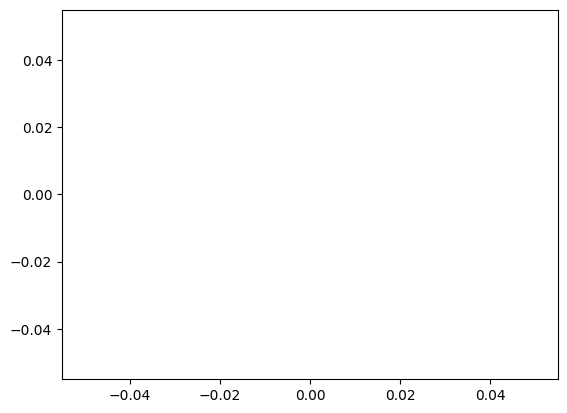

In [167]:
import matplotlib.patches as mpatches
color = ['orangered', 'lightgreen', 'darkorange', 'skyblue', 'lightcyan', 'darkviolet']
label = ['Target Link', 'Anatomy', 'Compound', 'Disease', 'Gene', 'Pharmacologic Class']
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color[i], label="{:s}".format(label[i]))[0] for i in range(len(label))]

In [168]:
labels = {}
for node in G.nodes:
    split = node.split('::')
    labels[node] = split[len(split)-1]

In [169]:
node_color = []
for node in G:
    if node == list(entity_dictionary[etype[0]].keys())[u] or node == list(entity_dictionary[etype[2]].keys())[v]:
        node_color.append('orangered')
    else:
        if node.startswith('Anatomy'):
            node_color.append('lightgreen')
        elif node.startswith('Compound'):
            node_color.append('darkorange')
        elif node.startswith('Disease'):
            node_color.append('skyblue')
        elif node.startswith('Gene'):
            node_color.append('lightcyan')
        elif node.startswith('Pharmacologic'):
            node_color.append('darkviolet')

In [180]:
edge_labels = {}
edge_label_target = {}
for i, row in df_explain.iterrows():
    split = row[1].split('::')
    pair = (row[0], row[2])
    
    if row[0] == list(entity_dictionary[etype[0]].keys())[u] and row[2] == list(entity_dictionary[etype[2]].keys())[v]:
        edge_label_target[pair] = row['Interaction-type']
    else:
        edge_labels[pair] = row['Interaction-type']

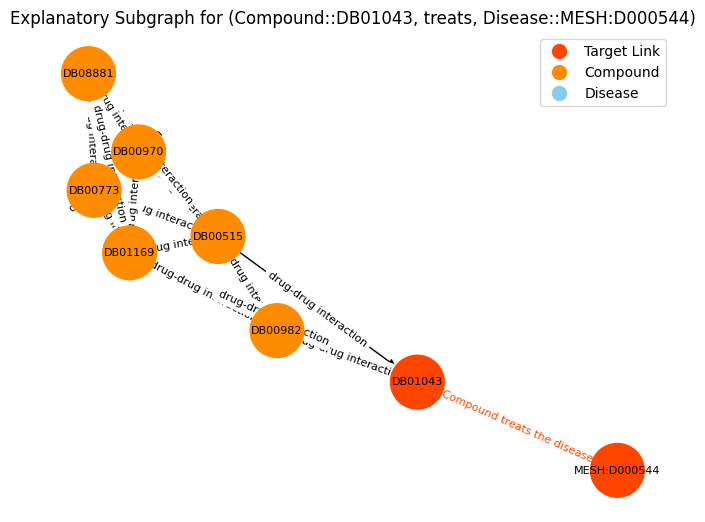

In [183]:
plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 2.5)
nx.draw(G, with_labels=True, node_color=node_color, node_size=3000, pos=pos, font_weight='bold', font_size=12, labels=labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_label_target, font_color='orangered', font_size=12)
plt.legend(handles=patches)
plt.title(f'Explanatory Subgraph for ({list(entity_dictionary[etype[0]].keys())[u]}, treats, {list(entity_dictionary[etype[2]].keys())[v]})')
plt.show()